In [2]:

import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import itertools 
import datetime
import cv2
import os
import io

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [3]:
test="/kaggle/input/brain-tumor-mri-dataset/Testing"
train="/kaggle/input/brain-tumor-mri-dataset/Training"

In [4]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

train_images = [] # training images.
train_labels  = [] # training labels.
test_images = [] # testing images.
test_labels = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join(train,label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        train_images.append(image)
        train_labels.append(labels.index(label))
    
    testPath = os.path.join(test,label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        test_images.append(image)
        test_labels.append(labels.index(label))
        
train_images = np.array(train_images) / 255.0 # normalize Images into range 0 to 1.
test_images = np.array(test_images) / 255.0

print(train_images.shape)
print(test_images.shape)

100%|██████████| 300/300 [00:03<00:00, 83.66it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


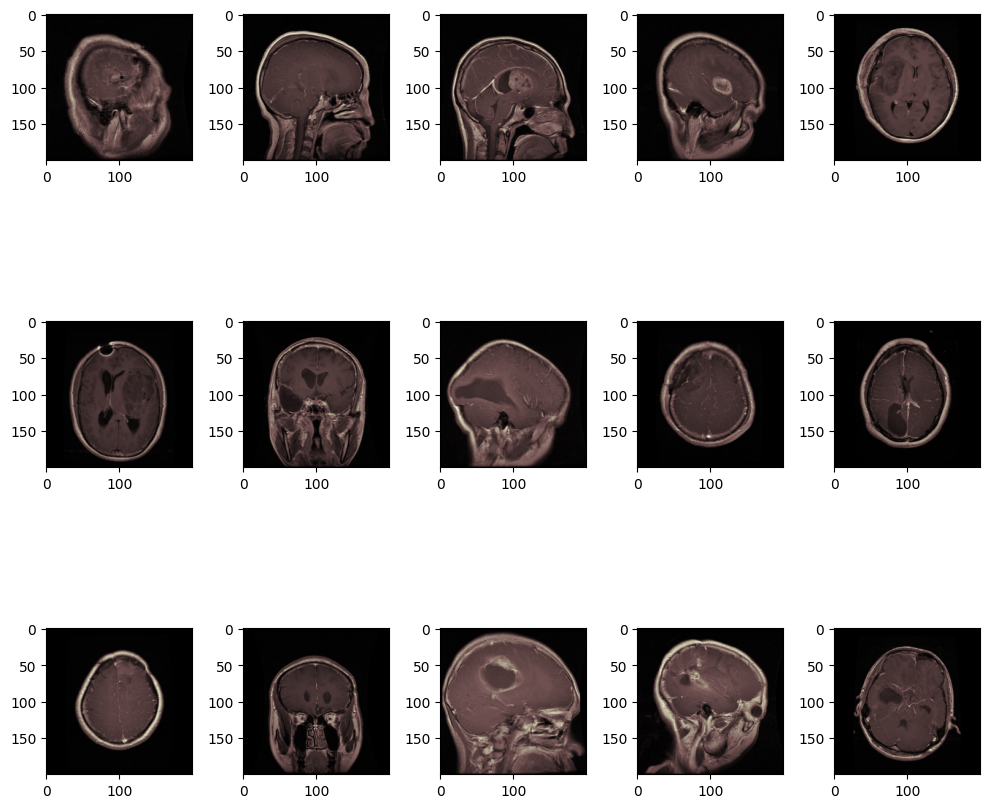

In [5]:
images = [train_images[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [6]:
train_images, train_labels = shuffle(train_images,train_labels, random_state=42) 

train_labels = tf.keras.utils.to_categorical(train_labels) #One Hot Encoding on the labels
test_labels = tf.keras.utils.to_categorical(test_labels)

train_images, val_images, train_labels, val_labels = train_test_split(train_images,train_labels, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(val_images.shape)

(1143, 200, 200, 3)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(train_images)  

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense

def convolutional_block(X, filters, stage, block, strides=(2, 2)):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides=strides, name=conv_name_base + '2a', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path 
    X = Conv2D(F2, (3, 3), padding='same', name=conv_name_base + '2b', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), name=conv_name_base + '2c', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides=strides, name=conv_name_base + '1', kernel_initializer='he_normal')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def identity_block(X, filters, stage, block):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), name=conv_name_base + '2a', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path 
    X = Conv2D(F2, (3, 3), padding='same', name=conv_name_base + '2b', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), name=conv_name_base + '2c', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def build_resnet50(input_shape, num_classes):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, filters=[64, 64, 256], stage=2, block='a', strides=(1, 1))
    X = identity_block(X, filters=[64, 64, 256], stage=2, block='b')
    X = identity_block(X, filters=[64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, filters=[128, 128, 512], stage=3, block='a')
    X = identity_block(X, filters=[128, 128, 512], stage=3, block='b')
    X = identity_block(X, filters=[128, 128, 512], stage=3, block='c')
    X = identity_block(X, filters=[128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, filters=[256, 256, 1024], stage=4, block='a')
    X = identity_block(X, filters=[256, 256, 1024], stage=4, block='b')
    X = identity_block(X, filters=[256, 256, 1024], stage=4, block='c')
    X = identity_block(X, filters=[256, 256, 1024], stage=4, block='d')
    X = identity_block(X, filters=[256, 256, 1024], stage=4, block='e')
    X = identity_block(X, filters=[256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, filters=[512, 512, 2048], stage=5, block='a')
    X = identity_block(X, filters=[512, 512, 2048], stage=5, block='b')
    X = identity_block(X, filters=[512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax', name='fc' + str(num_classes), kernel_initializer='glorot_uniform')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

# Create the ResNet50 model
input_shape = (200, 200, 3)
num_classes = 4
resnet50_model = build_resnet50(input_shape, num_classes)

# Print model summary
resnet50_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 100, 100,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 100, 100,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 100,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 49, 49,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 49, 49,    │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 49, 49,    │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 49, 49,    │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 49, 49,    │     36,928 │ activation_1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 49, 49,    │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 49, 49,    │          0 │ bn2a_branch2b[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 49, 49,    │     16,640 │ activation_2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 49, 49,    │     16,640 │ max_pooling2d[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 49, 49,    │      1,024 │ res2a_branch2c[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 49, 49,    │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 49,    │          0 │ bn2a_branch2c[0]

 Total params: 23,661,444 (90.26 MB)

 Trainable params: 23,608,324 (90.06 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
resnet50_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = resnet50_model.fit(train_images, train_labels, epochs=50, validation_data=(val_images, val_labels))

Epoch 1/50


I0000 00:00:1712818489.215270      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712818489.306826      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5618 - loss: 1.1580

W0000 00:00:1712818560.798823      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5623 - loss: 1.1566

W0000 00:00:1712818566.252667      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 155s 602ms/step - accuracy: 0.5628 - loss: 1.1553 - val_accuracy: 0.4934 - val_loss: 1.1889
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 293ms/step - accuracy: 0.7561 - loss: 0.6775 - val_accuracy: 0.5591 - val_loss: 1.1916
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.8282 - loss: 0.4846 - val_accuracy: 0.7402 - val_loss: 0.7374
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.8769 - loss: 0.3362 - val_accuracy: 0.6885 - val_loss: 2.1367
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.8985 - loss: 0.2670 - val_accuracy: 0.7760 - val_loss: 0.7923
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - accuracy: 0.9006 - loss: 0.2954 - val_accuracy: 0.7463 - val_loss: 0.9893
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - accuracy: 0.9194 - loss: 0.2201 - val_accuracy: 0.8626 - val_loss: 0.5324
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - accuracy: 0.9575 - loss: 0.1363 - va

In [10]:
test_loss, test_accuracy = resnet50_model.evaluate(test_images,test_labels)
print("Test Accuracy:", test_accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.8608 - loss: 0.9334
Test Accuracy: 0.9084668159484863


W0000 00:00:1712820592.002965      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


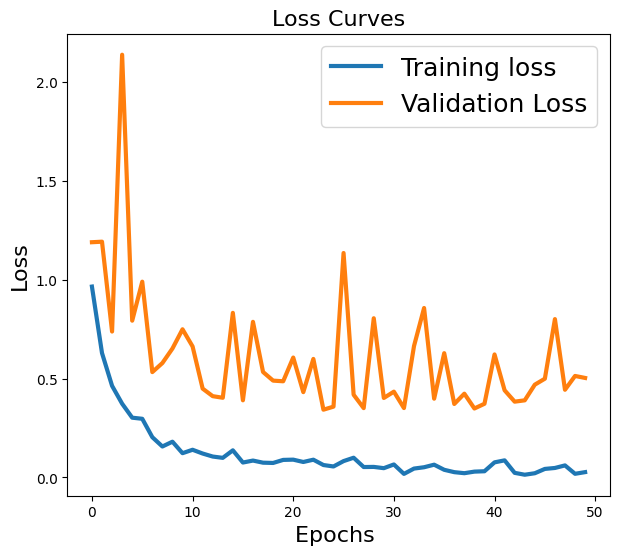

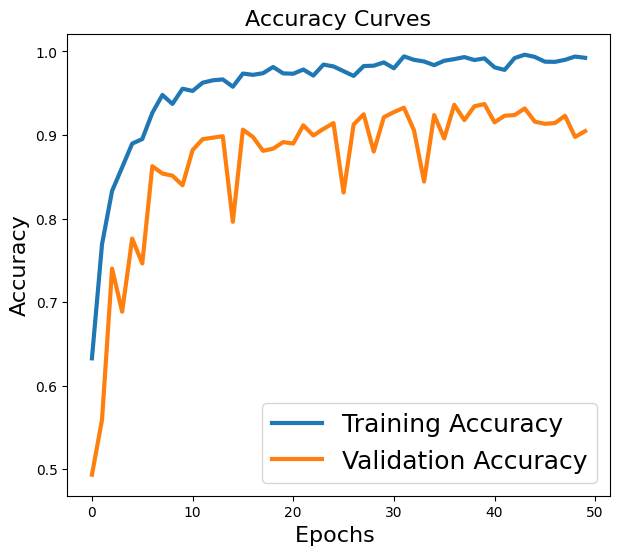

In [11]:
#Plot the Loss Curves
plt.figure(figsize=[7,6])
plt.plot(history.history['loss'],linewidth=3.0)
plt.plot(history.history['val_loss'],linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[7,6])
plt.plot(history.history['accuracy'],linewidth=3.0)
plt.plot(history.history['val_accuracy'],linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

 3/41 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step

W0000 00:00:1712820597.972529      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step


W0000 00:00:1712820604.452568      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.95      0.80      0.87       300
           1       0.76      0.92      0.83       306
           2       0.98      0.98      0.98       405
           3       0.96      0.92      0.94       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.92      0.91      0.91      1311



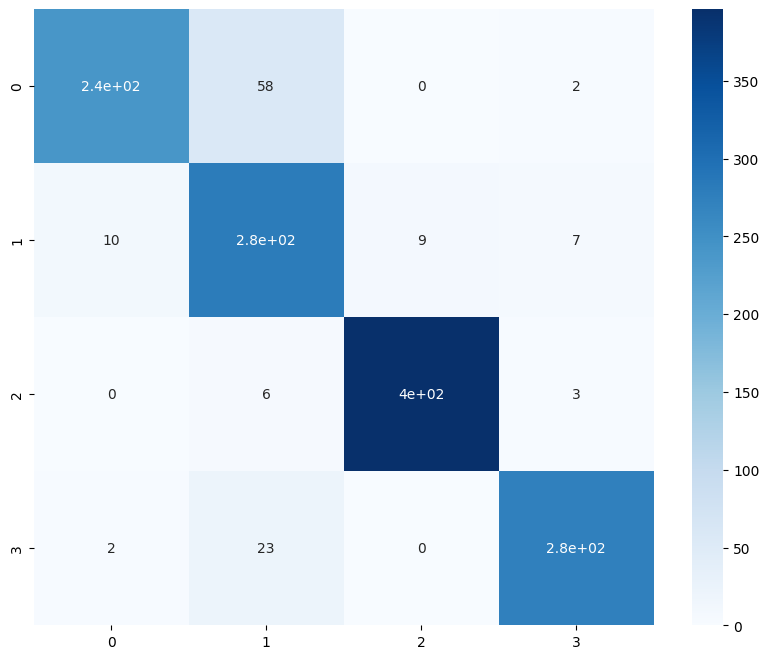

In [12]:

predicted_classes = np.argmax(resnet50_model.predict(test_images), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(test_labels,axis=1), predicted_classes)
plt.figure(figsize = (10, 8))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(test_labels,axis=1), predicted_classes))

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_vgg19(input_shape, num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Classification layer
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the VGG19 model
input_shape = (200, 200, 3)
num_classes = 4
vgg19_model = build_vgg19(input_shape, num_classes)

# Print model summary
vgg19_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    75,501,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,38

 Total params: 112,323,652 (428.48 MB)

 Trainable params: 112,323,652 (428.48 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
vgg19_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = vgg19_model.fit(train_images, train_labels, epochs=50, validation_data=(val_images, val_labels))

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.3061 - loss: 1.3457 - val_accuracy: 0.6352 - val_loss: 1.0542
Epoch 2/50


W0000 00:00:1712820842.647033      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.6331 - loss: 0.8573 - val_accuracy: 0.7787 - val_loss: 0.5443
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.7985 - loss: 0.5133 - val_accuracy: 0.8075 - val_loss: 0.4889
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.8428 - loss: 0.4138 - val_accuracy: 0.8688 - val_loss: 0.3837
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.8686 - loss: 0.3181 - val_accuracy: 0.8320 - val_loss: 0.4324
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.8986 - loss: 0.2768 - val_accuracy: 0.8556 - val_loss: 0.4158
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 487ms/step - accuracy: 0.9171 - loss: 0.2105 - val_accuracy: 0.9178 - val_loss: 0.2483
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.9472 - loss: 0.1488 - val_accuracy: 0.8924 - val_loss: 0.2922
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.9417 - loss: 0.1509 - val

In [15]:
test_loss, test_accuracy = vgg19_model.evaluate(test_images,test_labels)
print("Test Accuracy:", test_accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 806ms/step - accuracy: 0.9617 - loss: 0.4380
Test Accuracy: 0.9672006368637085


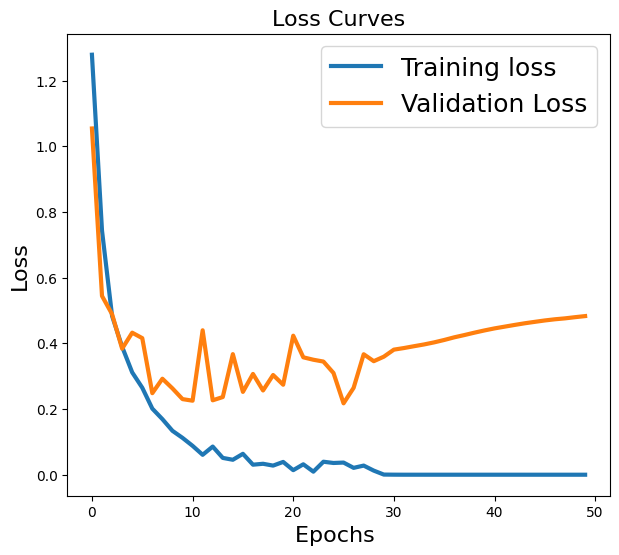

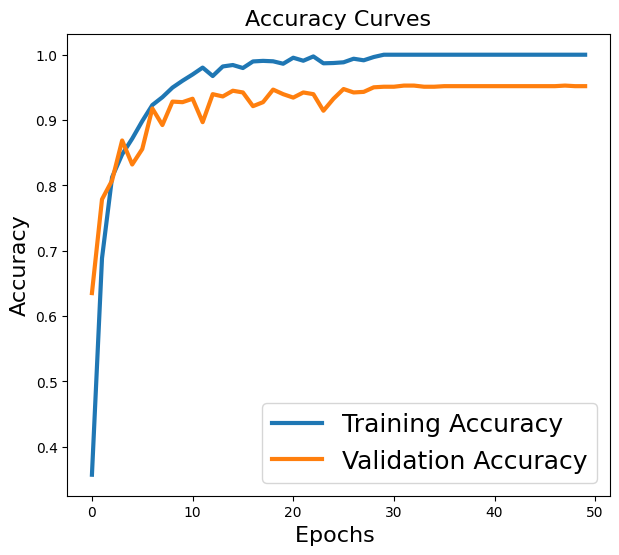

In [16]:
#Plot the Loss Curves
plt.figure(figsize=[7,6])
plt.plot(history.history['loss'],linewidth=3.0)
plt.plot(history.history['val_loss'],linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[7,6])
plt.plot(history.history['accuracy'],linewidth=3.0)
plt.plot(history.history['val_accuracy'],linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       300
           1       0.96      0.92      0.94       306
           2       0.98      1.00      0.99       405
           3       0.98      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



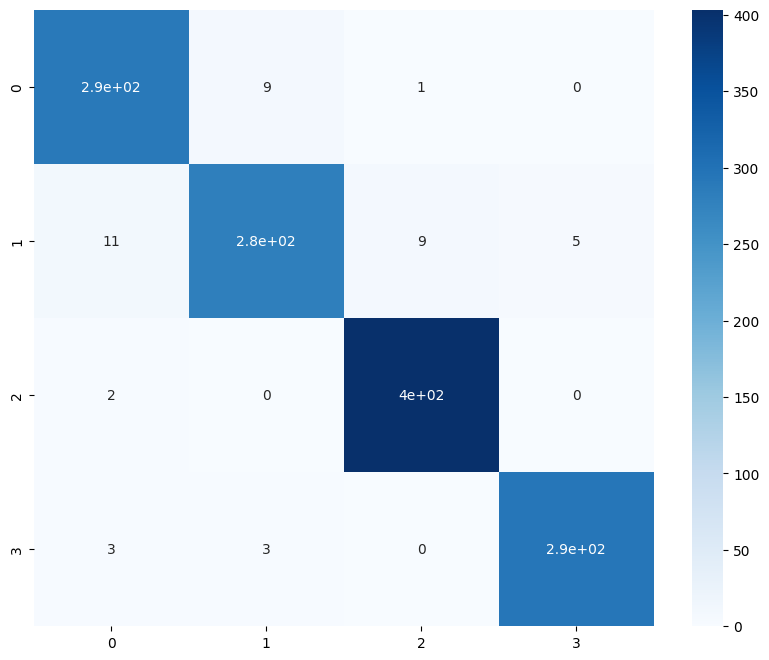

In [18]:

predicted_classes = np.argmax(vgg19_model.predict(test_images), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(test_labels,axis=1), predicted_classes)
plt.figure(figsize = (10, 8))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(test_labels,axis=1), predicted_classes))